In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb

import math
import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
%store -r mc_data

In [3]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        xlayer_model = load_model('./models/xlayer_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event
14   hasT
15   isInUT
16   isInVelo
17   isLong
18   isLong_fromB
19   isLong_fromB_more5
20   isLong_more5


In [5]:
mc_hits = mc_data.values

In [14]:
%store -r zLays
%store -r max_x
%store -r min_x
%store -r max_y
%store -r min_y
%store -r events

In [7]:
print(events)

[15837 15838 15839 15840 15841 15842 15843 15844 15845 15846 15847 15848
 15849 15850 15851 15852 15853 15854 15855 15856 15857 15858 15859 15860
 15861 15862 15863 15864 15865 15866 15867 15868 15869 15870 15871 15872
 15873 15874 15875 15876 15877 15878 15879 15880 15881 15882 15883 15884
 15885 15886 15887 15888 15889 15890 15891 15892 15893 15894 15895 15896
 15897 15898 15899 15900 15901 15902 15903 15904 15905 15906 15907 15908
 15909 15910 15911 15912 15913 15914 15915 15916 15917 15918 15919 15920
 15921 15922 15923 15924 15925 15926 15927 15928 15929 15930 15931 15932
 15933 15934 15935 15936 15937 15938 15939 15940 15941 17909 17910 17911
 17912 17913 17914 17915 17916 17917 17918 17919 17920 17921 17922 17923
 17924 17925 17926 17927 17928 17929 17930 17931 17932 17933 17934 17935
 17936 17937 17938 17939 17940 17941 17942 17943 17944 17945 17946 17947
 17948 17949 17950 17951 17952 17953 17954 17955 17956 17957 17958 17959
 17960 17961 17962 17963 17964 17965 17966 17967 17

In [10]:
def predictHeight(x0, x3, x_stereo, stereo_layer, first_layer, last_layer):
    
    z_stereo = zLays[stereo_layer]
    
    if (stereo_layer % 2 != 0):
        angle = 5
    else:
        angle = -5
        
    if (float(x3 - x0)  == 0):
        m = 1
    else:
        m = float(zLays[last_layer] - zLays[first_layer]) / float(x3 - x0)
    n = zLays[last_layer] - (m * x3)
    
    x_pred = (z_stereo - n) / m 
    beta = (x_pred - x_stereo) / (math.radians(angle) * z_stereo)
    return math.tan(beta) * z_stereo

In [51]:
#
# Test the NN model by using events not feeded as train 
#

def trackReconstruction(hits_total, index_tree):

    # Variables used for calculating metrics
    total_found = 0
    total = 0
    mean_size = np.zeros(3)

    # Variable defining the maximum number of hits gathered from the R-trees when using the predicted value from the NN
    max_hits_gathered = 12

    # Range in which valid hits are look up in the first R-tree
    long_range = 300

    X_classifier = []
    Y_classifier = []

    # For each particle of a given event
    for particle in hits_total:

        # Sometimes there are no PrHits for a given particle, so skip these ones
        if (len(particle[5]) > 1) and (particle[0] != 11) and (particle[0] != -11):

            found_num = 0            
            X_final = {}
            Zone_final = {}
            actual = -1

            # Extract all PrHits
            for i in range(0, len(particle[5])):
                if (actual != particle[8][i]):
                    X_final[particle[8][i]] = []
                    X_final[particle[8][i]].append(particle[5][i])
                    Zone_final[particle[8][i]] = particle[12][i]
                    actual = particle[8][i]
                    found_num += 1
                else:
                    X_final[actual].append(particle[5][i])

            # Check if there are minimum 12 hits found, as for the test, I am only working with complete tracks
            if not 0 in X_final or not 4 in X_final or not 8 in X_final:
                continue

            # List used to iterate over valid height found later on
            valid_y = {}

            # For each station
            for station in range(0,3):

                valid_y[station] = []

                # Compute the layer number based on station
                x0_layer = 0
                if (station == 1):
                    x0_layer = 4
                elif station == 2:
                    x0_layer = 8

                u_layer = x0_layer + 1
                v_layer = x0_layer + 2
                x1_layer = x0_layer + 3

                # Select both the first X position and UP/DOWN based on this
                first_hit = X_final[x0_layer][0]
                zone = Zone_final[x0_layer]

                # Predict all 3 following points based on the first hit selected
                predicted = (xlayer_model.predict(np.array([first_hit, x0_layer]).reshape(1,-1)))[0]
                mean_predicted = ((first_hit + predicted[0] + predicted[1] + predicted[2]) / 4)

                # Recolect all nearest hits from each layer using R-trees based on the X-position of the mean predicted
                found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, x1_layer, x1_layer, zone, zone), objects='raw'))
                found_layer3 = sorted(found, key=lambda x: np.abs(x[0]- mean_predicted))[:max_hits_gathered]
                arr_layer3 = np.unique(np.array(found_layer3), axis=0)

                found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, v_layer, v_layer, zone, zone), objects='raw'))
                found_layer2 = sorted(found, key=lambda x: np.abs(x[0] - mean_predicted))[:max_hits_gathered]
                arr_layer2 = np.unique(np.array(found_layer2), axis=0)

                found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, u_layer, u_layer, zone, zone), objects='raw'))
                found_layer1 = sorted(found, key=lambda x: np.abs(x[0] - mean_predicted))[:max_hits_gathered]
                arr_layer1 = np.unique(np.array(found_layer1), axis=0)

                for h3 in arr_layer3:

                    for h2 in arr_layer2:

                        # Predict height for each hit selected in the V layer
                        pred_h2 = predictHeight(first_hit, h3[0], h2[0], v_layer, x0_layer, x1_layer)

                        if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
                            continue

                        # And for each hit in the V layer, we look up at hits in the U layer with the same height
                        for h1 in arr_layer1:

                            # Predict height for hit in the U layer
                            pred_h1 = predictHeight(first_hit, h3[0], h1[0], u_layer, x0_layer, x1_layer)
                            if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
                                continue

                            if np.abs(pred_h2 - pred_h1) < 15.5:
                                # Insert into a new R-tree to enable search by height
                                # Store the valid height for later iterate over it
                                
                                valid_y[station].append([first_hit, h1[0], pred_h1, h2[0], pred_h2, h3[0], station, (h1[1],h2[1],h3[1])])

            valid_tracks = []
            for val in valid_y[0]:
                if (len(valid_y[1]) > 0 and len(valid_y[2]) > 0):
                    second_sort = sorted(valid_y[1], key = lambda p: np.abs(p[2] - val[2]))
                    if (np.abs(second_sort[0][2] - val[2]) < 100):
                        third_sort = sorted(valid_y[2], key = lambda p: np.abs(p[2] - second_sort[0][2]))
                        if np.abs(third_sort[0][2] - second_sort[0][2]) < 100:
                            valid_tracks.append([val, second_sort[0], third_sort[0]])

            
            repeated = 0
            len_tracks = len(valid_tracks)
            for track in valid_tracks:
                found = 0
                for station in range(0,3):
                    x0_layer = 0
                    if (station == 1):
                        x0_layer = 4
                    elif station == 2:
                        x0_layer = 8

                    u_layer = x0_layer + 1
                    v_layer = x0_layer + 2
                    x1_layer = x0_layer + 3

                    pos = 0
                    zone = 0
                    if (track[station][2] > 0):
                        zone = 1

                    for id in track[station][7]:
                        if (id in particle[4]):
                            found += 1
                            #index_tree.delete(int(id), (track[station][pos], track[station][pos], x0_layer + pos + 1, x0_layer + pos + 1, zone, zone))
                        pos += 1

                if (found > 6):
                    X_classifier.append(track[0][:7] + track[1][:7])
                    Y_classifier.append(1)
                    X_classifier.append(track[1][:7] + track[2][:7])
                    Y_classifier.append(1)
                    len_tracks -= 1
                else:
                    if repeated < 3:
                        X_classifier.append(track[0][:7] + track[1][:7])
                        Y_classifier.append(0)
                        X_classifier.append(track[1][:7] + track[2][:7])
                        Y_classifier.append(0)
                        repeated += 1

            if (repeated > 0):
                total_found += 1

            mean_size[0] += (len_tracks)
            total += 1
    #print("\nMean Total Found: %f" % (total_found/total))
    #print("\nMean Size: %f" % (mean_size[0]/total))
    return X_classifier, Y_classifier, total_found/total, mean_size[0]/total
    

In [52]:
mean = size = done = 0
test_events = events[10:300]

X_classifier = []
Y_classifier = []

p = index.Property()
p.dimension = 3
    
for event in test_events:
    particles_test_event = mc_hits[mc_hits[:,13] == event]
    # print("Event length %d " % len(particles_test_event))
    idx = {}
    mean_val = size_val = 0
    index_tree = index.Index(properties=p, interleaved=False)
    for hit in particles_test_event:
        if (len(hit[5]) > 1) and (hit[0] != 11) and (hit[0] != -11):
            for i in range(0,len(hit[5])):
                index_tree.insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i], hit[12][i], hit[12][i]), [float(hit[5][i]), int(hit[4][i])])

    X, Y, mean_val, size_val = trackReconstruction(particles_test_event, index_tree)
    
    X_classifier += X
    Y_classifier += Y
    mean += mean_val
    size += size_val
    done += 1
    print("Event %d/%d \t Acc: %f Size %f Proportion %f" % (done,len(test_events), mean_val, size_val, Y.count(0)/(Y.count(1) + 1)))
    
print("\nFinal Result:")
print("\t X_Size : %f" % (len(X_classifier)))
print("\t Y_Size: %f" % (len(Y_classifier)))
print("\t Y count 0 : %f" % (Y_classifier.count(0)))
print("\t Y count 1: %f" % (Y_classifier.count(1)))
print("\t Mean: %f" % (mean/len(test_events)))
print("\t Size: %f" % (size/len(test_events)))

Event 1/290 	 Acc: 0.000000 Size 0.000000 Proportion 0.000000
Event 2/290 	 Acc: 0.096774 Size 0.129032 Proportion 0.179775
Event 3/290 	 Acc: 0.063830 Size 0.106383 Proportion 0.169492
Event 4/290 	 Acc: 0.000000 Size 0.000000 Proportion 0.000000
Event 5/290 	 Acc: 0.196970 Size 0.333333 Proportion 0.269504
Event 6/290 	 Acc: 0.083333 Size 0.133333 Proportion 0.111888
Event 7/290 	 Acc: 0.111111 Size 0.222222 Proportion 0.179104
Event 8/290 	 Acc: 0.550802 Size 4.331551 Proportion 1.641791
Event 9/290 	 Acc: 0.000000 Size 0.000000 Proportion 0.000000
Event 10/290 	 Acc: 0.417266 Size 1.942446 Proportion 1.188285
Event 11/290 	 Acc: 0.100000 Size 0.150000 Proportion 0.173913
Event 12/290 	 Acc: 0.635294 Size 6.098039 Proportion 1.937916
Event 13/290 	 Acc: 0.195652 Size 0.826087 Proportion 0.410256
Event 14/290 	 Acc: 0.200000 Size 0.694118 Proportion 0.537931
Event 15/290 	 Acc: 0.157895 Size 0.473684 Proportion 0.530120
Event 16/290 	 Acc: 0.745098 Size 8.711485 Proportion 3.030675
E

Event 131/290 	 Acc: 0.488095 Size 3.196429 Proportion 1.118457
Event 132/290 	 Acc: 0.329787 Size 0.840426 Proportion 0.739394
Event 133/290 	 Acc: 0.568421 Size 5.773684 Proportion 1.534247
Event 134/290 	 Acc: 0.323529 Size 1.843137 Proportion 0.709677
Event 135/290 	 Acc: 0.191176 Size 0.411765 Proportion 0.322581
Event 136/290 	 Acc: 0.301205 Size 0.819277 Proportion 0.586826
Event 137/290 	 Acc: 0.292683 Size 1.121951 Proportion 0.594286
Event 138/290 	 Acc: 0.395522 Size 2.320896 Proportion 0.988679
Event 139/290 	 Acc: 0.116883 Size 0.194805 Proportion 0.196078
Event 140/290 	 Acc: 0.689655 Size 8.314176 Proportion 2.452088
Event 141/290 	 Acc: 0.305882 Size 2.647059 Proportion 0.731429
Event 142/290 	 Acc: 0.396825 Size 1.325397 Proportion 0.882096
Event 143/290 	 Acc: 0.609195 Size 4.695402 Proportion 1.514667
Event 144/290 	 Acc: 0.363636 Size 0.943182 Proportion 0.774566
Event 145/290 	 Acc: 0.600000 Size 4.050000 Proportion 1.490305
Event 146/290 	 Acc: 0.466258 Size 4.061

Event 260/290 	 Acc: 0.319328 Size 1.033613 Proportion 0.788732
Event 261/290 	 Acc: 0.554404 Size 4.860104 Proportion 1.319728
Event 262/290 	 Acc: 0.407143 Size 2.057143 Proportion 1.069959
Event 263/290 	 Acc: 0.565789 Size 4.302632 Proportion 1.398230
Event 264/290 	 Acc: 0.241935 Size 0.354839 Proportion 0.335878
Event 265/290 	 Acc: 0.455172 Size 3.482759 Proportion 1.180812
Event 266/290 	 Acc: 0.097222 Size 0.250000 Proportion 0.153846
Event 267/290 	 Acc: 0.273684 Size 0.915789 Proportion 0.493151
Event 268/290 	 Acc: 0.025000 Size 0.025000 Proportion 0.036364
Event 269/290 	 Acc: 0.000000 Size 0.000000 Proportion 0.000000
Event 270/290 	 Acc: 0.507812 Size 2.101562 Proportion 1.292181
Event 271/290 	 Acc: 0.142857 Size 0.185714 Proportion 0.211382
Event 272/290 	 Acc: 0.227273 Size 0.409091 Proportion 0.322581
Event 273/290 	 Acc: 0.454545 Size 2.500000 Proportion 1.196911
Event 274/290 	 Acc: 0.353448 Size 2.043103 Proportion 0.810811
Event 275/290 	 Acc: 0.307692 Size 1.000

In [53]:
print('Ration 1/0 ', Y_classifier.count(0)/len(X_classifier))

Ration 1/0  0.49183032345250005


In [54]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_classifier), np.array(Y_classifier))
print("X Train length: %d" % len(X_train))
print("X Test Length %d" % len(X_test))
print("Y Train length: %d" % len(y_train))
print("Y Test length: %d" % len(y_test))

X Train length: 85468
X Test Length 28490
Y Train length: 85468
Y Test length: 28490


In [55]:
train = xgb.DMatrix(data=np.array(X_train).reshape(-1,14),label=np.array(y_train).reshape(-1,1))
test = xgb.DMatrix(data=np.array(X_test).reshape(-1,14),label=np.array(y_test).reshape(-1,1))

In [56]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 20  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 1 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [57]:
booster = xgb.train(param,train,num_boost_round=num_trees)

In [58]:
predictions = booster.predict(test)

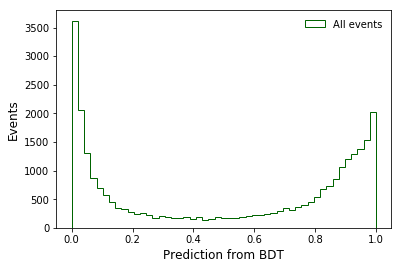

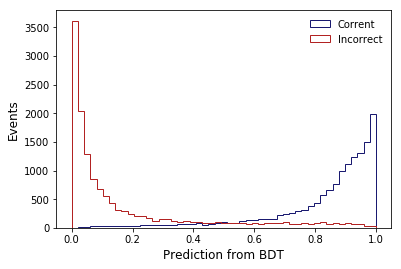

In [59]:
# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Corrent');
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='Incorrect');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

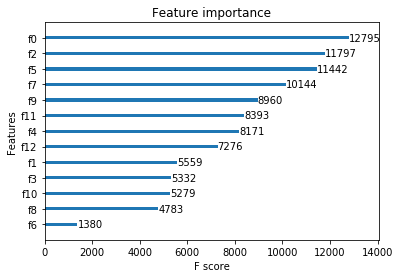

In [60]:
xgb.plot_importance(booster,grid=False);

In [61]:
accuracy = accuracy_score(y_test, predictions.round())
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.66%


In [49]:
X_train[0]
y_train[0]

0

In [62]:
test_matrix = xgb.DMatrix(data=np.array([-178.14001465, -277.80813599,  663.62765572, -204.62966919,
        658.02656845, -303.81500244,    0.        , -214.3400116 ,
       -304.35916138,  581.99802815, -242.22271729,  582.23712054,
       -332.26498413,    1.        ]).reshape(-1,14))
booster.predict(test_matrix)

array([0.00225049], dtype=float32)

In [63]:
booster.save_model('./models/xgboost_two_seeds_validation')